# Ancient Texts: Prepare new data frame for predictive algorithms
### This notebook contains
Creation of new dataframe and transformation of data for use in predictive algorithm training

### Goal
**Transform data set**
1. Create new df `df_joined` by joining selected columns from `all_texts_sentiment.csv` and `top_word_df.csv`, key: `Number`
2. Create features including new binary target variable `is_hymn`
3. Create visualizations of `whole_polarity` and `whole_subjectivity` by new feature `is_hymn`   
4. Balance data set as needed

*Specifically*
* Address texts with low word counts
* Address texts with many breaks
* Address word count imbalances

### Data
Original data sets: `all_texts_sentiment.csv` and `top_word_df.csv`

Final dateframe `ancient_for_ML` saved to csv\
This df contains 364 observations with 10 features

Unmodified features: `b_category`, `number`, `whole_polarity`, `whole_subjectivity`, `word_count`, and `tfidf_top_word`\
New features: `sentence_count`, `is_hymn`, `summary`, and `lemmatized_summaries`

Contents of final DataFrame `ancient_for_ML.csv` are listed at the end of this notebook

### Steps taken in this notebook
1. **Creation of New DataFrame with Sentiment and Polarity Scores, Word Counts, and Top Weighted Words**
   - Merged columns from `all_texts_sentiment.csv` and `top_word_df.csv` into new DataFrame
<br>
<br>
2.	**Feature Creation**
   - Applied NLTK sent_tokenize function on `cleaned_text` to generate `sentence_count`
   - Created binary target variable `is_hymn` derived from `b_category`, where:
     - 1 = tale
     - 0 = not tale
   - Generated `summary` of the texts exceeding 1200 words
   - Produced `lemmatized_summaries` for further analysis
<br>
<br>
3.	**Data Visualization**
   - Plotted relational histograms to visualize `word_count` by `is_hymn` variable
   - Created relational density histograms for `word_count` categorized by `is_hymn`
   - Generated boxplots to identify outliers in `word_count` based on `is_hymn` classification
   - Developed density histograms to illustrate distributions of `whole_polarity` and `whole_subjectivity` by `is_hymn`
<br>
<br>
4.	**Dataset Balancing**
   - Recategorized Inana-Dumuzi 'hymns' to have `is_hymn` set to 0
   - Removed fragmentary texts containing fewer than 30 words
   - Employed regex findall to assess percentage of breaks in texts and eliminated a few problematic entries
   - Conducted additional checks for other potential removals
   - Utilized gensim summarize() function to extract and summarize texts exceeding 1200 words, saving the results in `summary`
   - Applied py file `prepare_ancient_texts` to prepare text in `summary`, storing results in `lemmatized_summaries`
     - py file `prepare_ancient_text` includes functions that employ regex, word_tokenize and WordNetLemmatizer
   - Obtained new lemmatized counts for adjusted texts in `lemmatized_summaries`
   - Plotted new density histogram using `summary_counts` to assess balance of text word counts relative to target variable `is_hymn`
<br>
<br>
5.	**Feature Explanation and Data Export**
   - Explained new features created during analysis (see end of notebook)
   - Saved updated DataFrame to a CSV file named `ancient_for_ML`

In [1]:
# Import standard operational packages
import numpy as np
import pandas as pd

# Import NLP packages
import re
import gensim
from gensim.summarization import summarize
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

# Import visualization package
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Import functions from prepare_ancient_text py file
# Contains functions: simple_cleaning, ancient_stopwords, and prepare_text
import prepare_ancient_text as ancient

# Set Jupyter to display all of the columns (no redaction)
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package punkt to /Users/ilona/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ilona/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ilona/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Create new dataframe with sentiment and polarity scores, word counts, and top weighted words
* `all_texts_sentiment.csv`
* `top_word_df.csv`

#### Read in `all_texts_sentiment.csv`

In [2]:
sentiment = pd.read_csv('all_texts_sentiment.csv')
sentiment.head(2).round(2)

,A_category,B_category,Period,Dynasty,God,2nd_god,Other_divine,Person,Number,Title,Place,Text,American,cleaned_sentences,agg_polarity,agg_subjectivity,joined_text,whole_polarity,whole_subjectivity
0,Narrative and mythological compositions,Narratives featuring deities,NaN,NaN,Enki,Ninhursaga,NaN,NaN,1.1.1,Enki and Ninhursaga,NaN,1-4. Pure are the cities -- and you are the o...,1-4. pure are the cities -- and you are the o...,[' pure are the cities; and you are the ones t...,0.12,0.20,pure are the cities; and you are the ones to ...,0.33,0.56
1,Narrative and mythological compositions,Narratives featuring deities,NaN,NaN,Enki,Ninmah,NaN,NaN,1.1.2,Enki and Ninmah,NaN,"1-11. In those days, in the days when heaven ...","1-11. in those days, in the days when heaven ...","[' in those days, in the days when heaven and ...",0.06,0.24,"in those days, in the days when heaven and ea...",0.11,0.45


In [3]:
# Get basic stats
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   A_category          381 non-null    object 
 1   B_category          381 non-null    object 
 2   Period              151 non-null    object 
 3   Dynasty             151 non-null    object 
 4   God                 238 non-null    object 
 5   2nd_god             10 non-null     object 
 6   Other_divine        28 non-null     object 
 7   Person              184 non-null    object 
 8   Number              381 non-null    object 
 9   Title               381 non-null    object 
 10  Place               28 non-null     object 
 11  Text                381 non-null    object 
 12  American            381 non-null    object 
 13  cleaned_sentences   381 non-null    object 
 14  agg_polarity        381 non-null    float64
 15  agg_subjectivity    381 non-null    float64
 16  joined_t

#### Features of interest
| Column                                           | Contents                                                                                                                                                                   |
|------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| B_category                                         | genres of texts         |
| God                                         | featured god in text         |
| Number                                         | original catalog number and key        |
| American                                         | text Americanized in str format          |
| cleaned_sentences                          | cleaned Americanized text where each value is a list of sentences and since saved to a csv, some value formats have been altered                                        |
| agg_polarity                                   | aggregated polarity scores                                 |
| agg_subjectivity                                    | aggregated subjectivity scores              |
| joined_text            |`cleaned_sentences` joined                         |
| whole_polarity       | whole assessment scores for each `joined_text`                        |
| whole_subjectivity                                  | whole assessment scores for each `joined_text`   |


In [4]:
# Examine a text in 'cleaned_sentences'
print(sentiment.iloc[125, 8], sentiment.iloc[125, 9])
print(sentiment.iloc[125, 13])

2.5.5.2 A praise poem of Lipit-Eshtar (Lipit-Eshtar B)
[' lipit-eštar, proud king, enthroned prince, most seemly offshoot of kingship, who walks like utu, brilliant light of the land, lofty in nobility, riding on the great divine powers; who settles the people in the four quarters; favored by enlil, beloved by ninlil, trustworthy youth with shining eyes, worthy of the throne-dais, whose seemly head is adorned with the tiara, the good heress, who holds in his hand   is perfect with the scepter over the black-headed, prince lipit-eštar, son of enlil, wise shepherd, who leads the people to let them relax …… in pleasant shade, lord, great bison, beloved by anu !', 'your trust is put in mother ninlil ; lipit-eštar, you exert great power.', 'you who speak as sweet as honey, whose name suits the mouth, longed-for husband of inana, to whom enki gave broad wisdom as a gift!', 'nisaba, the woman radiant with joy, the true woman, the scribe, the lady who knows everything, guides your fingers on t

In [5]:
# Examine same text in 'joined_text'
print(sentiment.iloc[125, 8], sentiment.iloc[125, 9])
sentiment.iloc[125, 16]

2.5.5.2 A praise poem of Lipit-Eshtar (Lipit-Eshtar B)


" lipit-eštar, proud king, enthroned prince, most seemly offshoot of kingship, who walks like utu, brilliant light of the land, lofty in nobility, riding on the great divine powers; who settles the people in the four quarters; favored by enlil, beloved by ninlil, trustworthy youth with shining eyes, worthy of the throne-dais, whose seemly head is adorned with the tiara, the good heress, who holds in his hand   is perfect with the scepter over the black-headed, prince lipit-eštar, son of enlil, wise shepherd, who leads the people to let them relax …… in pleasant shade, lord, great bison, beloved by anu ! your trust is put in mother ninlil ; lipit-eštar, you exert great power. you who speak as sweet as honey, whose name suits the mouth, longed-for husband of inana, to whom enki gave broad wisdom as a gift! nisaba, the woman radiant with joy, the true woman, the scribe, the lady who knows everything, guides your fingers on the clay she makes them put beautiful wedges on the tablets and ad

In [6]:
# Select columns to work with
sentiment_for_join = sentiment[['B_category', 'God', 'Number', 'joined_text', 'whole_polarity', 'whole_subjectivity']].reset_index(drop=True)
print(sentiment_for_join.info())
sentiment_for_join.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   B_category          381 non-null    object 
 1   God                 238 non-null    object 
 2   Number              381 non-null    object 
 3   joined_text         381 non-null    object 
 4   whole_polarity      381 non-null    float64
 5   whole_subjectivity  381 non-null    float64
dtypes: float64(2), object(4)
memory usage: 18.0+ KB
None


,B_category,God,Number,joined_text,whole_polarity,whole_subjectivity
0,Narratives featuring deities,Enki,1.1.1,pure are the cities; and you are the ones to ...,0.330364,0.559201
1,Narratives featuring deities,Enki,1.1.2,"in those days, in the days when heaven and ea...",0.110600,0.449011
2,Narratives featuring deities,Enki,1.1.3,"grandiloquent lord of heaven and earth, self-...",0.382723,0.596019
3,Narratives featuring deities,Enki,1.1.4,"in those remote days, when the fates were det...",0.380222,0.576855
4,Narratives featuring deities,Enlil,1.2.1,"there was a city, there was a city; the one w...",0.355707,0.528989


#### Read in `top_word_df.csv`

In [7]:
top_word_df = pd.read_csv('top_word_df.csv')
top_word_df.head(2).round(2)

,B_category,God,Number,Person,Title,joined_text,lemmatized,word_count,token_counts,tfidf_top_word,tfidf_weight
0,Narratives featuring deities,Enki,1.1.1,NaN,Enki and Ninhursaga,pure are the cities; and you are the ones to ...,pure city you one they allotted pure dilmun la...,1440,"[('you', 51), ('he', 45), ('enki', 39), ('mont...",oil like,0.46
1,Narratives featuring deities,Enki,1.1.2,NaN,Enki and Ninmah,"in those days, in the days when heaven and ea...",day day heaven earth created night night heave...,825,"[('not', 31), ('enki', 27), ('you', 22), ('i',...",could not,0.63


In [8]:
# Get basic stats
top_word_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   B_category      381 non-null    object 
 1   God             238 non-null    object 
 2   Number          381 non-null    object 
 3   Person          184 non-null    object 
 4   Title           381 non-null    object 
 5   joined_text     381 non-null    object 
 6   lemmatized      381 non-null    object 
 7   word_count      381 non-null    int64  
 8   token_counts    381 non-null    object 
 9   tfidf_top_word  381 non-null    object 
 10  tfidf_weight    381 non-null    float64
dtypes: float64(1), int64(1), object(9)
memory usage: 32.9+ KB


#### Features of interest
| Column                                           | Contents                                                                                                                                                                   |
|------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Number                                         | original catalog number and key        |
| word_count                                         | word count for each text in `lemmatized` column          |
| tfidf_top_word                          | top weighted bi-gram for each text in `lemmatized` column       |

In [9]:
# Examine text row 125 in 'joined_text'
print(top_word_df.iloc[125, 2], top_word_df.iloc[125, 4])
top_word_df.iloc[125, 5]

2.5.5.2 A praise poem of Lipit-Eshtar (Lipit-Eshtar B)


" lipit-eštar, proud king, enthroned prince, most seemly offshoot of kingship, who walks like utu, brilliant light of the land, lofty in nobility, riding on the great divine powers; who settles the people in the four quarters; favored by enlil, beloved by ninlil, trustworthy youth with shining eyes, worthy of the throne-dais, whose seemly head is adorned with the tiara, the good heress, who holds in his hand   is perfect with the scepter over the black-headed, prince lipit-eštar, son of enlil, wise shepherd, who leads the people to let them relax …… in pleasant shade, lord, great bison, beloved by anu ! your trust is put in mother ninlil ; lipit-eštar, you exert great power. you who speak as sweet as honey, whose name suits the mouth, longed-for husband of inana, to whom enki gave broad wisdom as a gift! nisaba, the woman radiant with joy, the true woman, the scribe, the lady who knows everything, guides your fingers on the clay she makes them put beautiful wedges on the tablets and ad

In [10]:
# Examine a text row 125 in 'lemmatized'
print(top_word_df.iloc[125, 2], top_word_df.iloc[125, 4])
top_word_df.iloc[125, 6]

2.5.5.2 A praise poem of Lipit-Eshtar (Lipit-Eshtar B)


'lipit-eštar proud king enthroned prince seemly offshoot kingship walk like utu brilliant light land lofty nobility riding great divine power settle people four quarter favored enlil beloved ninlil trustworthy youth shining eye worthy throne-dais whose seemly head adorned tiara good heress hold hand perfect scepter black-headed prince lipit-eštar son enlil wise shepherd lead people let relax pleasant shade lord great bison beloved anu trust put mother ninlil lipit-eštar you exert great power you speak sweet honey whose name suit mouth longed-for husband inana enki gave broad wisdom gift nisaba woman radiant joy true woman scribe lady know everything guide finger clay she make put beautiful wedge tablet adorns golden stylus nisaba generously bestowed upon you measuring rod surveyor gleaming yardstick tablet confer wisdom lipit-eštar enlil son you realised justice righteousness lord goodness cover everything far horizon king lipit-eštar counsellor huge intelligence never tire discussion 

In [11]:
# Select columns
top_word_for_join = top_word_df[['Number', 'word_count', 'tfidf_top_word']].reset_index(drop=True)
print(top_word_for_join.info())
top_word_for_join.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Number          381 non-null    object
 1   word_count      381 non-null    int64 
 2   tfidf_top_word  381 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.1+ KB
None


,Number,word_count,tfidf_top_word
0,1.1.1,1440,oil like
1,1.1.2,825,could not
2,1.1.3,2247,placed charge
3,1.1.4,629,lapis lazuli
4,1.2.1,763,enlil lord


In [12]:
# Merge 'sentiment_for_join' and 'top_word_for_join'
df_joined = sentiment_for_join.merge(top_word_for_join[['Number', 'word_count', 'tfidf_top_word']],on='Number', how='outer') # 'outer' includes all keys
print(df_joined.info())
df_joined.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381 entries, 0 to 380
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   B_category          381 non-null    object 
 1   God                 238 non-null    object 
 2   Number              381 non-null    object 
 3   joined_text         381 non-null    object 
 4   whole_polarity      381 non-null    float64
 5   whole_subjectivity  381 non-null    float64
 6   word_count          381 non-null    int64  
 7   tfidf_top_word      381 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 26.8+ KB
None


,B_category,God,Number,joined_text,whole_polarity,whole_subjectivity,word_count,tfidf_top_word
0,Narratives featuring deities,Enki,1.1.1,pure are the cities; and you are the ones to ...,0.330364,0.559201,1440,oil like
1,Narratives featuring deities,Enki,1.1.2,"in those days, in the days when heaven and ea...",0.110600,0.449011,825,could not


#### Perform a simple cleaning on `joined_text`

In [13]:
# Apply 'simple_cleaning' function in imported py file prepare_ancient_text
df_joined['cleaned_text'] = df_joined['joined_text'].apply(ancient.simple_cleaning)
df_joined.head(2)

,B_category,God,Number,joined_text,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,cleaned_text
0,Narratives featuring deities,Enki,1.1.1,pure are the cities; and you are the ones to ...,0.330364,0.559201,1440,oil like,pure are the cities; and you are the ones to w...
1,Narratives featuring deities,Enki,1.1.2,"in those days, in the days when heaven and ea...",0.110600,0.449011,825,could not,"in those days, in the days when heaven and ear..."


In [14]:
# Lowercase columns for consistency
df_joined.rename(columns={'B_category': 'b_category', 'God': 'god', 'Number': 'number'}, inplace=True)
df_joined.columns

Index(['b_category', 'god', 'number', 'joined_text', 'whole_polarity',
       'whole_subjectivity', 'word_count', 'tfidf_top_word', 'cleaned_text'],
      dtype='object')

## Create Features
* `sentence count`: number of sentences in `joined_text` using NLTK sent_tokenize function
* `is_hymn`: binary 0/1 if text is a hymn

### Create feature `sentence_count` from `cleaned_text`

In [15]:
# Create function to count sentences
def count_sentences(text):
    return len(sent_tokenize(text))

In [16]:
# Apply 'count_sentences' function to 'cleaned_text'
# Create new column
df_joined['sentence_count'] = df_joined['cleaned_text'].apply(count_sentences)
df_joined.head(2)

,b_category,god,number,joined_text,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,cleaned_text,sentence_count
0,Narratives featuring deities,Enki,1.1.1,pure are the cities; and you are the ones to ...,0.330364,0.559201,1440,oil like,pure are the cities; and you are the ones to w...,167
1,Narratives featuring deities,Enki,1.1.2,"in those days, in the days when heaven and ea...",0.110600,0.449011,825,could not,"in those days, in the days when heaven and ear...",81


#### Save new df and drop no longer needed `joined_text`

In [17]:
# Drop 'joined_text'
df_drop = df_joined.drop('joined_text', axis=1)
df_drop.head(2)

,b_category,god,number,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,cleaned_text,sentence_count
0,Narratives featuring deities,Enki,1.1.1,0.330364,0.559201,1440,oil like,pure are the cities; and you are the ones to w...,167
1,Narratives featuring deities,Enki,1.1.2,0.110600,0.449011,825,could not,"in those days, in the days when heaven and ear...",81


In [18]:
# Save final joined df to a CSV 
df_drop.to_csv('joined_df.csv', index=False)

In [19]:
df0 = pd.read_csv('joined_df.csv')
print(df0.info())
df0.head(2).round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   b_category          381 non-null    object 
 1   god                 238 non-null    object 
 2   number              381 non-null    object 
 3   whole_polarity      381 non-null    float64
 4   whole_subjectivity  381 non-null    float64
 5   word_count          381 non-null    int64  
 6   tfidf_top_word      381 non-null    object 
 7   cleaned_text        381 non-null    object 
 8   sentence_count      381 non-null    int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 26.9+ KB
None


,b_category,god,number,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,cleaned_text,sentence_count
0,Narratives featuring deities,Enki,1.1.1,0.33,0.56,1440,oil like,pure are the cities; and you are the ones to w...,167
1,Narratives featuring deities,Enki,1.1.2,0.11,0.45,825,could not,"in those days, in the days when heaven and ear...",81


### Create feature `is_hymn` from `b_category`
Assign texts to either hymn or not hymn
* 1 = hymn, praise, or prayer
* 0 = not hymn, praise, or prayer

In [20]:
print(df0.b_category.nunique())
df0.b_category.unique()

25


array(['Narratives featuring deities', 'Narratives featuring heroes',
       'King lists and other compositions', 'City laments',
       'Royal praise poetry and hymns to deities on behalf of rulers',
       'Praise poetry and hymns for unknown rulers',
       'Royal correspondence', 'Other letters and letter-prayers',
       'Hymns addressed to deities',
       'Hymns addressed to or concerning temples', 'School stories',
       'Debate poems', 'Dialogues and diatribes', 'Personal laments',
       'Reflective compositions', 'Lu-digira compositions',
       'Types of song', 'Didactic compositions', 'Short tales',
       'Offering compositions', 'Other', 'Lexical compositions',
       'Animal fables', 'Proverb collections', 'Other proverbs'],
      dtype=object)

**Hymn, praise, or prayer**
> 'Royal praise poetry and hymns to deities on behalf of rulers'\
> 'Praise poetry and hymns for unknown rulers'\
> 'Hymns addressed to deities'\
> 'Hymns addressed to or concerning temples'\
> 'Other letters and letter-prayers'

**Not hymn, praise, or prayer**
> 'Narratives featuring deities',
> 'Narratives featuring heroes',
> 'King lists and other compositions',
> 'City laments',
> 'Royal correspondence',
> 'School stories',
> 'Debate poems',
> 'Dialogues and diatribes',
> 'Personal laments',
> 'Lu-digira compositions',
> 'Types of song',
> 'Didactic compositions',
> 'Short tales',
> 'Animal fables',
> 'Offering compositions',
> 'Proverb collections',
> 'Other proverbs,
> 'Reflective compositions',
> 'Other',
> 'Lexical compositions'

In [21]:
# Create new binary column hymn/prayer or not hymn/prayer called 'is_hymn'
df0['is_hymn'] = df0['b_category'].apply(lambda x: 1 if x in ['Royal praise poetry and hymns to deities on behalf of rulers', 
                                                              'Praise poetry and hymns for unknown rulers', 
                                                              'Hymns addressed to deities', 
                                                              'Hymns addressed to or concerning temples',
                                                              'Other letters and letter-prayers'
                                                             ] 
                                         else 0
                                        )
df0.head()

,b_category,god,number,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,cleaned_text,sentence_count,is_hymn
0,Narratives featuring deities,Enki,1.1.1,0.330364,0.559201,1440,oil like,pure are the cities; and you are the ones to w...,167,0
1,Narratives featuring deities,Enki,1.1.2,0.110600,0.449011,825,could not,"in those days, in the days when heaven and ear...",81,0
2,Narratives featuring deities,Enki,1.1.3,0.382723,0.596019,2247,placed charge,"grandiloquent lord of heaven and earth, self-r...",236,0
3,Narratives featuring deities,Enki,1.1.4,0.380222,0.576855,629,lapis lazuli,"in those remote days, when the fates were dete...",72,0
4,Narratives featuring deities,Enlil,1.2.1,0.355707,0.528989,763,enlil lord,"there was a city, there was a city; the one we...",131,0


#### Check balance of data set

In [22]:
# Get distribution statistics for 'is_hymn' by 'word_count'
df0.groupby('is_hymn')['word_count'].describe().round()

,count,mean,std,min,25%,50%,75%,max
is_hymn,,,,,,,,
0,131.0,718.0,853.0,8.0,150.0,359.0,1052.0,5305.0
1,250.0,266.0,326.0,4.0,108.0,175.0,305.0,2836.0


In [23]:
# Get distribution statistics for 'is_hymn' by 'sentence_count'
df0.groupby('is_hymn')['sentence_count'].describe().round()

,count,mean,std,min,25%,50%,75%,max
is_hymn,,,,,,,,
0,131.0,92.0,94.0,3.0,21.0,57.0,138.0,452.0
1,250.0,33.0,33.0,1.0,13.0,25.0,40.0,213.0


#### Note
* 'is_hymn=1' has almost twice as many observations
* 'is_hymn=0' has on average well over twice as many words
* The standard deviation for 'is_hymn=0' is more extreme than 'is_hymn=1'

*Steps to balance*
* Some texts have almost no words and should be removed
* Some texts have over 3000 words and should be summarized
* Perhaps upscale 'is_hymn=0' texts
* Recategorize Inana and Dumuzi 'hymns' as narratives

## Create Visualizations
* Relational histograms for `word_count` by `is_hymn`
* Relational density histograms for `word_count` by `is_hymn`
* Boxplots to show outliers for `word_count` by `is_hymn`
* Relational density histograms for `whole_polarity` and `whole_subjectivity` distributions by `is_hymn` for interest

### Relational histograms for `word_count` by `is_hymn`

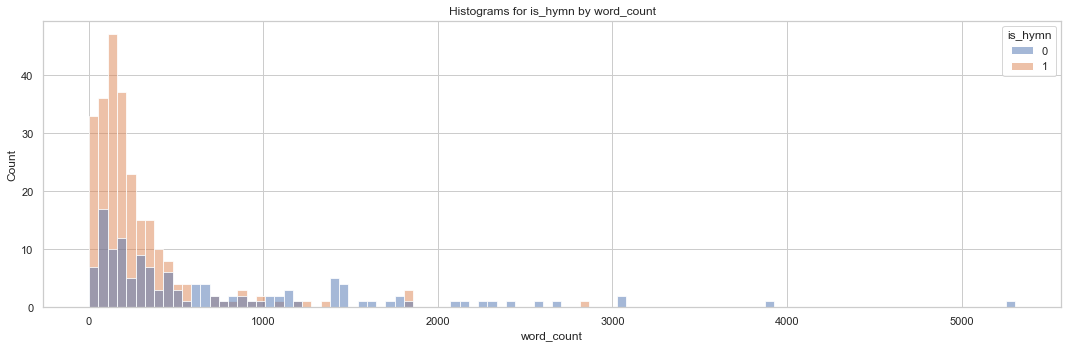

In [24]:
# Plot relational histograms for 'word_count' by 'is_hymn'
plt.figure(figsize = (15, 5))

sns.histplot(data=df0, x='word_count', hue='is_hymn', multiple='layer', bins=100)
plt.title('Histograms for is_hymn by word_count')

plt.tight_layout()
plt.show();

### Relational density histograms for `word_count` by `is_hymn`
* stat='density'\
By setting stat='density' the heights of the histogram bars represent the *proportion* of the total data that falls within each bin, where the density is set to 1 <br>
Setting to 1 allows for a more meaningful comparison between uneven datasets by showing how frequently different ranges of word counts occur within each category

* kde=True\
Setting KDE to true overlays a smooth Kernel Density Estimate curve on top of the histogram <br>
The KDE curve provides an estimate of the probability density

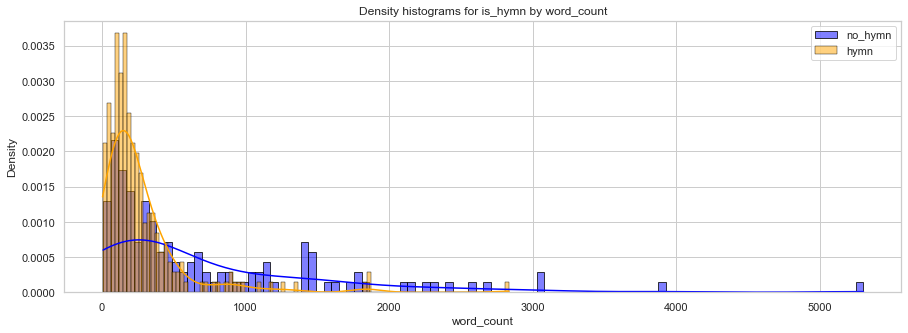

In [25]:
# Plot density histograms for 'word_count' by 'is_hymn'
plt.figure(figsize=(15, 5))

no_hymn = df0.loc[df0['is_hymn']== 0]['word_count']
hymn = df0.loc[df0['is_hymn']== 1]['word_count']
plt.title('Density histograms for is_hymn by word_count')

# Plot for 'no_hymn'
sns.histplot(no_hymn, kde=True, color='blue', label='no_hymn', edgecolor='black', stat='density', bins=100)

# Plot for 'hymn'
sns.histplot(hymn, kde=True, color='orange', label='hymn', edgecolor='black', stat='density', bins=100)

plt.legend()
plt.show()

##### Note: 'is_hymn = 0' has fewer observations and many genres within it have only 1 example
Distributions have similar arcs

### Box plots for `word_count` by `is_hymn`

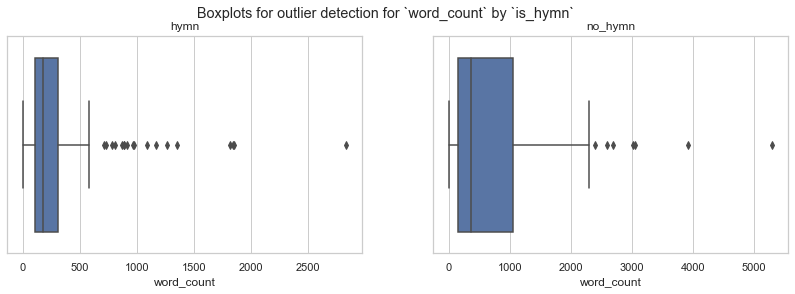

In [26]:
# Create enlarged boxplots to show outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 4))   # Set spacing and dimensions for subplots

fig.suptitle('Boxplots for outlier detection for `word_count` by `is_hymn`')

sns.boxplot(ax=axes[0], x = hymn, showfliers=True).set(title='hymn')
sns.boxplot(ax=axes[1], x = no_hymn, showfliers=True).set(title='no_hymn')

plt.show();

#### Results for `word_count` plots
(Keeping in mind that `word_count` is based on the texts lemmatized

*Mean Word Count*
* At ~ 718 words on average 'is_hymn = 0' texts are generally much longer and may either be repetitive  or likely detailed
* At an average of 266 words, 'is_hymn = 1' texts are much shorter

*Standard Deviation, percentiles, and skew*
* With an SD of 853.45, 'is_hymn = 0' texts demonstrate a high degree of variability in text length
  * The extreme range of 8 to 5,305 words likely reveals gross inconsistency between the genres which comprise 'is_hymn=0'
  * With the 75th percentile at 1,051.5 words, a significant number of texts are very long
  * With the boxplot demonstrating a strong right (positive) skew and extended whiskers a few exceptionally long texts are driving the average higher
* Conversely, 'is_hymn = 1' texts with an SD of 325.55, demonstrate less variability
  * Although they range from 4 to 2,836 words, they are a bit more consistent in length
  * With the 75th percentile at 305 words, the majority of texts are relatively short and focused
  * The boxplot also demonstrates a strong right (positive) skew indicating that a few texts may either be repetitive or highly detailed

*Conclusion*
* 'is_hymn = 0' texts are comparatively extensive and detailed. They are more suitable for in-depth analyses.
* 'is_hymn = 1' texts are defined more by brevity and, assumed, clarity, making them ideal for succinct communication of ideas.

### Relational density histograms for `whole_polarity` and `whole_subjectivity` distributions by `is_hymn`

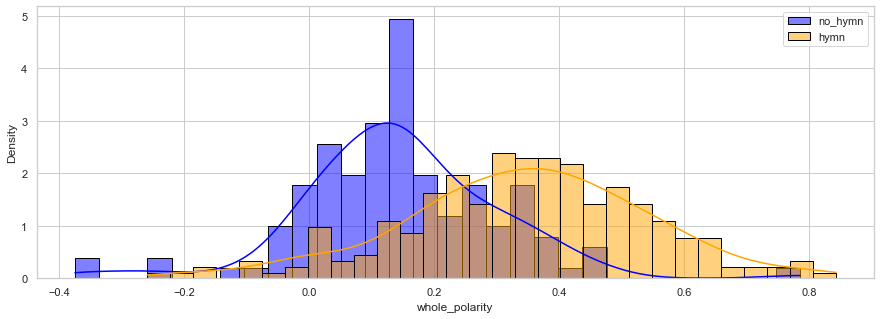

In [27]:
# Plot density histograms for 'whole_polarity' by 'is_hymn'
plt.figure(figsize=(15, 5))

hymn = df0.loc[df0['is_hymn']== 1]['whole_polarity']
no_hymn = df0.loc[df0['is_hymn']== 0]['whole_polarity']

# Plot for 'no_hymn'
sns.histplot(no_hymn, kde=True, color='blue', label='no_hymn', edgecolor='black', stat='density', bins=30)

# Plot for 'hymn'
sns.histplot(hymn, kde=True, color='orange', label='hymn', edgecolor='black', stat='density', bins=30)

plt.legend()
plt.show()

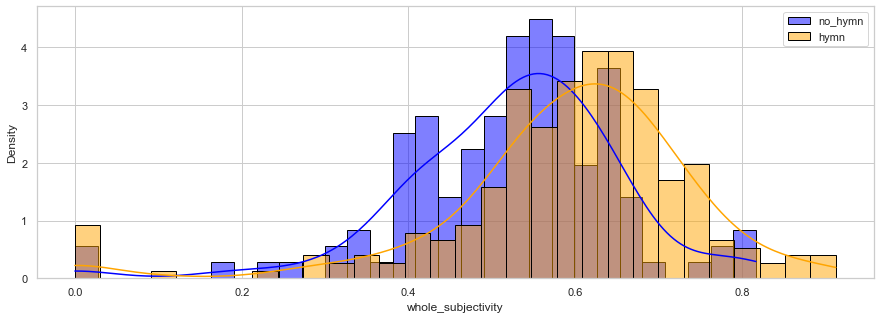

In [28]:
# Plot density histograms for 'whole_subjectivity' by 'is_hymn'
plt.figure(figsize=(15, 5))

hymn = df0.loc[df0['is_hymn']== 1]['whole_subjectivity']
no_hymn = df0.loc[df0['is_hymn']== 0]['whole_subjectivity']

# Plot for 'no_hymn'
sns.histplot(no_hymn, kde=True, color='blue', label='no_hymn', edgecolor='black', stat='density', bins=30)

# Plot for 'hymn'
sns.histplot(hymn, kde=True, color='orange', label='hymn', edgecolor='black', stat='density', bins=30)

plt.legend()
plt.show()

#### Results for `whole_polarity` and `whole_subjectivity` distributions by `is_hymn`
`whole_polarity` : range -1 to 1
* Taken together, the corpus demonstrates a slightly positive tone, with few texts deemed to be negative
* 'is_hymn=0' texts are most likely to have a neutral to ever so slightly positive tone, though a few texts could be more negative
* Conversely, 'is_hymn=1' texts are most likely to be positive or even very positive in tone

`whole_subjectivity`: range 0-1
* Taken together, the corpus demonstrates an almost 50/50 chance that a text will be either more or less subjective 
* 'is_hymn=0' texts are more likely to be less subjective (more truthful); however, more texts creep into the subjective territory
* Conversely, 'is_hymn=1' texts are far more likely to be subjective (less truthful)

## Balance dataset
*Steps to balance*
* Recategorize Inana and Dumuzi 'hymns' as narratives
* Some texts have almost no words and should be removed
* Check `b_category` genres with few texts
* Check for other removals
* Some texts have over 3000 words and should be summarized
* Perhaps upscale 'is_hymn=0' texts even though not horribly imbalanced
* Perhaps double text of 'is_hymn=1' texts to be more aligned with length on 'is_hymn=0'

### Recategorize Inana and Dumuzi 'hymns' as narratives ('is_hymn=0') because they could be categorized as stories

In [29]:
# Make copy of df
modified = df0.copy()

# Locate Inana and Dumuzi texts
print(modified.shape)
modified.god.unique()

(381, 10)


array(['Enki', 'Enlil', 'Inana', 'Inana and Dumuzid', 'Nanna-Suen',
       'Ninurta', 'Martu', 'Ningishzida', 'Gods', nan, 'Pabilsag', 'Bau',
       'Nanna', 'Utu', 'Ninlil', 'Nergal', 'An', 'Suen', 'Meshlamta-ea',
       'Kindattu', 'Nanaya', 'Ninisina', 'Ninsiana', 'Ningublaga',
       'Nuska', 'Dagan', 'Ishkur', 'Numushda', 'Haia', 'Asarluhi',
       'Marduk', 'Nintinuga', 'personal deity', 'Ninshubur', 'Damgalnuna',
       'Hendursaga', 'Nanshe', 'Ninazu', 'Ninimma', 'Ninkasi', 'Nintur',
       'Nisaba', 'Nungal', 'Shara', 'Shul-pa-e', 'Sadarnuna', 'Kusu'],
      dtype=object)

In [30]:
# Locate Inana and Dumuzi texts and change to 0 = not hymn
modified.loc[modified['god']=='Inana and Dumuzid', 'is_hymn'] = 0

In [31]:
# Check that it worked
modified[modified['god'] == 'Inana and Dumuzid']

,b_category,god,number,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,cleaned_text,sentence_count,is_hymn
11,Narratives featuring deities,Inana and Dumuzid,1.4.1,0.148933,0.529165,2148,underworld she,from the great heaven she set her mind on the ...,294,0
12,Narratives featuring deities,Inana and Dumuzid,1.4.1.1,-0.015402,0.518470,421,come let,a small demon opened his mouth and said to the...,61,0
13,Narratives featuring deities,Inana and Dumuzid,1.4.1.3,0.016964,0.425893,326,sister i,…… my ……. …… my lacerated eyes ……. …… my lacer...,87,0
14,Narratives featuring deities,Inana and Dumuzid,1.4.3,-0.064776,0.400130,1423,sheepfold cow-pen,his heart was full of tears as he went out int...,169,0
15,Narratives featuring deities,Inana and Dumuzid,1.4.4,0.113927,0.640301,630,you lament,"she can make the lament for you, my dumuzid, t...",67,0
232,Hymns addressed to deities,Inana and Dumuzid,4.08.01,0.085100,0.468079,271,you already,"the brother speaks gently to his sister, utu s...",23,0
233,Hymns addressed to deities,Inana and Dumuzid,4.08.02,0.504279,0.744133,177,shall take,"my dearest, my dearest, my dearest, my darling...",23,0
234,Hymns addressed to deities,Inana and Dumuzid,4.08.03,0.350461,0.512573,236,let bring,"my sister, what have you been doing in the hou...",36,0
235,Hymns addressed to deities,Inana and Dumuzid,4.08.04,0.366102,0.676736,109,let go,"as i was strolling, as i was strolling, as i w...",13,0
236,Hymns addressed to deities,Inana and Dumuzid,4.08.05,0.498750,0.810000,71,tree he,"he has sprouted, he has burgeoned, he is well-...",7,0


### Investigate texts to see if some texts can be removed

#### Remove fragmentary texts
* remove texts with fewer than 30 words

In [32]:
# Get descriptive stats for short texts
short = modified[modified['word_count'] <= 30]
short.groupby('is_hymn')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
is_hymn,,,,,,,,
0,3.0,13.0,7.000000,8.0,9.00,10.0,15.5,21.0
1,10.0,14.6,8.921883,4.0,6.75,13.0,21.5,29.0


In [33]:
# Since only 13, check out short texts
print(short.shape)
short

(13, 10)


,b_category,god,number,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,cleaned_text,sentence_count,is_hymn
57,Royal praise poetry and hymns to deities on be...,NaN,2.4.1.8,0.0000,0.675000,20,king land,"ur-namma, king of the land ……. …… far and dist...",8,1
74,Royal praise poetry and hymns to deities on be...,NaN,2.4.2.23,0.2125,0.487500,22,you pay,…… does not release ……. …… does not release ……...,11,1
87,Royal praise poetry and hymns to deities on be...,NaN,2.4.4.9,0.0000,0.000000,4,No significant terms,"king šu-suen, forceful lord,",1,1
98,Royal praise poetry and hymns to deities on be...,NaN,2.5.2.3,0.0000,0.000000,9,uru anu,…… august divine powers ……. may …… prolong …… ...,5,1
163,Royal praise poetry and hymns to deities on be...,NaN,2.8.3.4,0.0000,0.000000,6,holy heart,"he causes brilliance, he …… from his holy heart.",1,1
171,Praise poetry and hymns for unknown rulers,NaN,2.99.b,0.0000,0.000000,12,take counsel,…… who was given a long-lasting kingship by en...,4,1
172,Praise poetry and hymns for unknown rulers,NaN,2.99.c,0.7500,0.775000,14,bright mountain,…… like a great mountain. …… gilgameš cools of...,6,1
173,Praise poetry and hymns for unknown rulers,NaN,2.99.d,0.8000,0.750000,29,shepherd crook,"nibru, the city where the divine powers are pr...",5,1
186,Royal correspondence,NaN,3.1.13.1,0.0000,0.000000,8,No significant terms,to aradĝu …… …… šulgi …… as regards your conce...,4,0
242,Hymns addressed to deities,Inana and Dumuzid,4.08.12,0.6500,0.400000,10,one you,"my valiant nanna, who ……, my dear one, you lov...",2,0


In [34]:
# Keep only texts with more than 30 words
modified2 = modified[modified['word_count'] >= 30].reset_index(drop=True)

print(modified2.shape)
modified2.groupby('is_hymn')['word_count'].describe().round()

(368, 10)


,count,mean,std,min,25%,50%,75%,max
is_hymn,,,,,,,,
0,155.0,639.0,807.0,37.0,150.0,309.0,824.0,5305.0
1,213.0,288.0,345.0,31.0,113.0,183.0,337.0,2836.0


In [35]:
# Check it worked by row count
381-13

368

### Check for predominantly broken texts
Create lambda function where
* re.findall finds all occurrences of '……' followed by any of !.,;? in `cleaned_text` column
  * set re.escape() function to treat all escape characters as literal strings 
* use len() functon to count matches
* store in new column `count_break`
* use loc[:, 'count_break'] where : indexer is set to select all rows

In [36]:
# Check for predominantly broken texts
breaks = modified2[['b_category', 'number', 'word_count', 'cleaned_text', 'sentence_count', 'is_hymn']].reset_index(drop=True)

# Define base value
base_value = '……'

# Create lambda function to count all variations of base value ('……') followed by punctuation
breaks.loc[:, 'count_break'] = breaks['cleaned_text'].apply(
    lambda x: len(re.findall(rf'{re.escape(base_value)}[!.,;?]*', x))
)

In [37]:
# Get percentage of breaks
breaks['percentage'] = (breaks['count_break'] / breaks['word_count']) * 100
over_30 = breaks[breaks['percentage'] > 30]

# Check by percentage
print(over_30.shape)
over_30.sort_values(by='percentage', ascending=False).round()

(22, 8)


,b_category,number,word_count,cleaned_text,sentence_count,is_hymn,count_break,percentage
150,Royal praise poetry and hymns to deities on be...,2.8.2.1,68,…… acting as its lord …… …… the black-headed …...,32,1,64,94.0
110,Royal praise poetry and hymns to deities on be...,2.5.4.16,31,"great warrior, ……. brave ……. his radiance ……. ...",19,1,24,77.0
164,Royal praise poetry and hymns to deities on be...,2.8.5.a,87,on a shining day may …… for you! on a bright d...,28,1,46,53.0
245,Hymns addressed to deities,4.08.32,52,…… my side. …… on a bed dripping with honey. …...,21,0,27,52.0
266,Hymns addressed to deities,4.13.b,41,…… puts in order the great cattle pens …… for ...,9,1,19,46.0
249,Hymns addressed to deities,4.12.2,95,"…… watching over ……, gathering together …… the...",13,1,41,43.0
83,Royal praise poetry and hymns to deities on be...,2.4.4.5,34,warrior from birth ……. šagbatuku. wise šu-suen...,17,1,14,41.0
175,Royal correspondence,3.1.10,67,"say to puzur-šulgi, commander of the fortress ...",17,0,27,40.0
172,Royal correspondence,3.1.06.1,82,say to aradĝu this is what your lord šulgi say...,18,0,33,40.0
281,Hymns addressed to deities,4.22.3,32,…… escorts her to ……. she sails on the euphrat...,8,1,12,38.0


In [38]:
# Get genre counts
over_30.b_category.value_counts()

Royal praise poetry and hymns to deities on behalf of rulers    10
Hymns addressed to deities                                       7
Royal correspondence                                             2
Other proverbs                                                   1
Reflective compositions                                          1
Narratives featuring deities                                     1
Name: b_category, dtype: int64

In [39]:
# Get counts by target variable 'is_hymn'
over_30.is_hymn.value_counts()

1    16
0     6
Name: is_hymn, dtype: int64

In [40]:
# Check out 2.5.4.16
print(breaks.iloc[110, 3])

great warrior, ……. brave ……. his radiance ……. …… the cities and settlements. roaring lion …… to ……. ninurta. uta-ulu ……. sa-gida. lord ……. ĝišgiĝal of the sa-gida. …… in the ubšu-unkena. …… the status of enlil ……. …… the power of the great mountain enlil ……. …… my man ……. prince išme-dagan ……. …… ninurta ……. …… fifty-headed battle-mace ……. …… išme-dagan ……. …… great copper throne …….


In [41]:
# Check out 2.8.5.a
print(breaks.iloc[164, 3])

on a shining day may …… for you! on a bright day may your heart ……! the bright day when utu the judge ……. …… his pleasure, his fulfilment. …… the staff of anu, in heaven and earth. …… marduk ……. approx. there ……. before utu and nanše ……. before abī-ešuḫ ……. …… your divinity ……. …… your lot. the door …… to the house ……. …… day and night ……. …… from the mouth, its tongue ……. your personal god …… like life. your protective goddess …… life. …… life …… prayer. in those days, in those far-off years …… the holy hand …… his protective goddess ……. nisaba, the lady of ereš, ……. …… a jar in which there was barley. walking …… …… on roads and routes ……. …… words which he had uttered, ways ……. …… a hired worker, like a midwife, a female weaver ……. …… who spoke to utu ……, …… who spoke to nanna ……. he who enters a house ……. …… small and great ……. …… sitting on his chair, lying on his bed, …… your ways, your personal god …… …… years of life, months of peace in a place of contentment.


##### Notes:
*Drop*
* 2.8.2.1 (150) has 94% breaks
* 2.5.4.16 (110) has 77% breaks, 31 words, 19 sentences, and 24 breaks
* 2.8.5.a (164) has 53% breaks and no verbs
* 4.08.32 (245) has 52% breaks and only 52 words

At this point do not drop more, because saving text is more important

In [42]:
# Drop rows 150, 110, 164, and 245
modified3 = modified2.drop([150, 110, 164, 245], inplace=False).reset_index(drop=True)

In [43]:
# Check it worked
print(modified3.shape)
modified3[modified3['number'] == '2.8.5.a']

(364, 10)


,b_category,god,number,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,cleaned_text,sentence_count,is_hymn


In [44]:
# Get descriptive statistics for 'is_hymn'
modified3.groupby('is_hymn')['word_count'].describe().round()

,count,mean,std,min,25%,50%,75%,max
is_hymn,,,,,,,,
0,154.0,643.0,808.0,37.0,152.0,310.0,824.0,5305.0
1,210.0,291.0,346.0,31.0,114.0,185.0,338.0,2836.0


#### Check out genre counts within `b_category` by `is_hymn`

In [45]:
# Check class balance for 'B_category', 'is_hymn = 1'
modified3[modified3['is_hymn'] == 1]['b_category'].value_counts()

Royal praise poetry and hymns to deities on behalf of rulers    114
Hymns addressed to deities                                       75
Other letters and letter-prayers                                 17
Hymns addressed to or concerning temples                          3
Praise poetry and hymns for unknown rulers                        1
Name: b_category, dtype: int64

In [46]:
# Check class balance for 'B_category', 'is_hymn = 0'
modified3[modified3['is_hymn'] == 0]['b_category'].value_counts()

Proverb collections                  26
Narratives featuring deities         26
Royal correspondence                 25
Hymns addressed to deities           24
Narratives featuring heroes          10
King lists and other compositions     7
Debate poems                          6
City laments                          5
Other proverbs                        5
Types of song                         3
Lu-digira compositions                3
Dialogues and diatribes               2
Short tales                           2
Didactic compositions                 2
Offering compositions                 2
Lexical compositions                  1
Personal laments                      1
Other                                 1
School stories                        1
Animal fables                         1
Reflective compositions               1
Name: b_category, dtype: int64

In [47]:
# Examine contents of single categories with few texts
subset = modified3.loc[modified3['b_category'].isin(['Animal fables',
                                         'Other',
                                         'School stories',
                                         'Reflective compositions',
                                         'Personal laments',
                                         'Lexical compositions'
                                        ]
                                                   )].reset_index(drop=True)
subset

,b_category,god,number,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,cleaned_text,sentence_count,is_hymn
0,School stories,NaN,5.1.3,0.325406,0.626158,517,i shall,the supervisor speaks one-time member of the s...,63,0
1,Personal laments,NaN,5.2.4,-0.002681,0.568077,693,young man,a person should steadfastly proclaim the exalt...,98,0
2,Reflective compositions,NaN,5.2.5,0.327273,0.400000,59,year king,…… is not made ……. …… those men were overthrow...,8,0
3,Other,NaN,5.7.a,0.000000,0.000000,37,No significant terms,"a seal inscribed with the name of ur-dun, the ...",3,0
4,Lexical compositions,NaN,5.9.1,0.295645,0.504919,691,enter you,"my fish, i have built you a home! my fish, i h...",80,0
5,Animal fables,NaN,5.9.2,0.265875,0.458208,823,laid egg,what do they say in the reedbeds whose growth ...,113,0


In [48]:
# Check out Reflective compositions
print(subset.iloc[2, 7])

…… is not made ……. …… those men were overthrown. …… the king he reigned, years! …… the king, the one who ascended to heaven …… he who, like zi-ud-sura, tried to find life …… he who was honored and then seized …… was not rivalled in the land …… the kings, the leaders of former days ……, have they not been born …… can my hand reach them …… no one knows it. …… is like the twinkling of an eye. who would consider …… without cheerfulness to be superior to death, years of silence …… just one day of happiness. having been given …… the gods, life was sought for ……. …… the share of mankind, …… live in the house of the young men.


In [49]:
# Check out Other
print(subset.iloc[3, 7])

a seal inscribed with the name of ur-dun, the merchant, was lost. in accordance with the word of the assembly, the herald has sounded the horn throughout all the streets no one now has any claim against him. lu-suena lu-gena, the governor-general; lugal-melem, the governor and temple administrator were their …… and …… their seals ; zuzu, the scholar; si-du, the scribe; allub, the steward; bansagen, the lament singer; ullia, the mayor; and the herald are the witnesses.


#### Note:
* No reason to remove only 1 text genres
* Address 'No significant terms' label
* Address texts with 0 in both `whole_polarity` and `whole_subjectivity`

### Investigate texts to see if more texts can be removed

#### Check distribution of 'tfidf_top_word = No significant terms'

In [50]:
# Check distribution of 'tfidf_top_word = No significant terms'
no_sig = modified3[modified3['tfidf_top_word'] == 'No significant terms']
no_sig

,b_category,god,number,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,cleaned_text,sentence_count,is_hymn
330,Other,NaN,5.7.a,0.0,0.0,37,No significant terms,"a seal inscribed with the name of ur-dun, the ...",3,0


In [51]:
# Check out 5.7.a
print(modified3.iloc[330, 7])

a seal inscribed with the name of ur-dun, the merchant, was lost. in accordance with the word of the assembly, the herald has sounded the horn throughout all the streets no one now has any claim against him. lu-suena lu-gena, the governor-general; lugal-melem, the governor and temple administrator were their …… and …… their seals ; zuzu, the scholar; si-du, the scribe; allub, the steward; bansagen, the lament singer; ullia, the mayor; and the herald are the witnesses.


#### Check out texts with 0 in `both whole_polarity` and `whole_subjectivity`

In [52]:
no_whole = modified3.query('whole_polarity == 0 & whole_subjectivity == 0')
no_whole

,b_category,god,number,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,cleaned_text,sentence_count,is_hymn
191,Other letters and letter-prayers,NaN,3.3.04,0.0,0.0,54,you one,say to the governor and temple administrator w...,6,1
330,Other,NaN,5.7.a,0.0,0.0,37,No significant terms,"a seal inscribed with the name of ur-dun, the ...",3,0


In [53]:
# Check out 3.3.04
modified3.iloc[191, 7]

'say to the governor and temple administrator what ur-enlila says the irrigation ditch which has been cleared was bringing water but enlil-diĝirĝu enlil-aĝu enlilaĝu and ḫanzamu have drawn off the water and taken it from the ditch. and what lugal-ane says i proposed, water should be brought the irrigation should be done on the basis of one ditch for me, one ditch for you and one ditch for the governor, but they did not agree. your canal has no workers but its ditch brings water. it brings water for me unchecked. my workforce is inadequate so send me five or able-bodied men. it is urgent.'

##### Note:
* Keep both 5.7.a and 3.3.04, since they're full texts
* Clean for spaces again when summarizing

In [54]:
# Save modified3 df to a csv for ease
modified3.to_csv('modified_df.csv', index=False)

In [55]:
df0 = pd.read_csv('modified_df.csv')
print(df0.info())
df0.head(2).round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   b_category          364 non-null    object 
 1   god                 232 non-null    object 
 2   number              364 non-null    object 
 3   whole_polarity      364 non-null    float64
 4   whole_subjectivity  364 non-null    float64
 5   word_count          364 non-null    int64  
 6   tfidf_top_word      364 non-null    object 
 7   cleaned_text        364 non-null    object 
 8   sentence_count      364 non-null    int64  
 9   is_hymn             364 non-null    int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 28.6+ KB
None


,b_category,god,number,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,cleaned_text,sentence_count,is_hymn
0,Narratives featuring deities,Enki,1.1.1,0.33,0.56,1440,oil like,pure are the cities; and you are the ones to w...,167,0
1,Narratives featuring deities,Enki,1.1.2,0.11,0.45,825,could not,"in those days, in the days when heaven and ear...",81,0


## Extract and summarize
* Import gensim 3.8.3 to use summarize function
* Apply cleaning function to `clean_text`
* Create `extrative_summary function` on `clean_text` where
  * only rows where `word_count` is over 1200 words are summarized
  * texts are summarized to a max of 1200 words (word_count=200) rather than ratio (ratio=0.2 [20%])
  * rows where `word_count` is under 1200 words are returned whole swath

Note:\
Using the unlemmatized text may introduce noise in summarization due to excessive punctuation or complex verbal forms 

In [56]:
# Apply 'simple_cleaning' function in imported py file prepare_ancient_text
df0['cleaned_text'] = df0['cleaned_text'].apply(ancient.simple_cleaning)
df0.head(2).round(2)

,b_category,god,number,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,cleaned_text,sentence_count,is_hymn
0,Narratives featuring deities,Enki,1.1.1,0.33,0.56,1440,oil like,pure are the cities; and you are the ones to w...,167,0
1,Narratives featuring deities,Enki,1.1.2,0.11,0.45,825,could not,"in those days, in the days when heaven and ear...",81,0


In [57]:
print(df0.iloc[330, 7])

a seal inscribed with the name of ur-dun, the merchant, was lost. in accordance with the word of the assembly, the herald has sounded the horn throughout all the streets no one now has any claim against him. lu-suena lu-gena, the governor-general; lugal-melem, the governor and temple administrator were their …… and …… their seals ; zuzu, the scholar; si-du, the scribe; allub, the steward; bansagen, the lament singer; ullia, the mayor; and the herald are the witnesses.


In [58]:
# Create extractive_summary function on 'clean_text'

def extractive_summary(row):
    def joined_text(text):  # Function to ensure text is joined properly
        return ' '.join(text.split()) 

    if row['word_count'] > 1200:
        summarized_text = summarize(row['cleaned_text'], word_count=1200)
        return joined_text(summarized_text)  # Call 'joined_text' function
        
    else:
        return joined_text(row['cleaned_text'])  # Call 'joined_text' function to ensure all text is joined

In [59]:
# Apply 'extractive_summary', creating new 'summary' column
df0['summary'] = df0.apply(extractive_summary, axis=1)

In [60]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   b_category          364 non-null    object 
 1   god                 232 non-null    object 
 2   number              364 non-null    object 
 3   whole_polarity      364 non-null    float64
 4   whole_subjectivity  364 non-null    float64
 5   word_count          364 non-null    int64  
 6   tfidf_top_word      364 non-null    object 
 7   cleaned_text        364 non-null    object 
 8   sentence_count      364 non-null    int64  
 9   is_hymn             364 non-null    int64  
 10  summary             364 non-null    object 
dtypes: float64(2), int64(3), object(6)
memory usage: 31.4+ KB


#### Check the it worked
* Compare text 1.1.1 (0,7) which has a 1440 word count to summary (0,10)
* Check out text 2.5.5.2 (now 120,7) which has a word count under 1200 and should not have been summarized

In [61]:
# Check out 1.1.1
print(df0.iloc[0, 7])

pure are the cities; and you are the ones to whom they are allotted. pure is dilmun land. pure is sumer; and you are the ones to whom it is allotted. pure is dilmun land. pure is dilmun land. virginal is dilmun land. virginal is dilmun land. pristine is dilmun land. he laid her down all alone in dilmun, and the place where enki had lain down with his spouse, that place was still virginal, that place was still pristine. he laid her down all alone in dilmun, and the place where enki had lain down with ninsikila, that place was virginal, that place was pristine. in dilmun the raven was not yet cawing, the partridge not cackling. the lion did not slay, the wolf was not carrying off lambs, the dog had not been taught to make kids curl up, the pig had not learned that grain was to be eaten. when a widow has spread malt on the roof, the birds did not yet eat that malt up there. the pigeon then did not tuck the head under its wing. no eye-diseases said there i am the eye disease. no headache s

In [62]:
print(df0.iloc[0, 10])

pure is dilmun land. pure is dilmun land. pure is dilmun land. virginal is dilmun land. virginal is dilmun land. pristine is dilmun land. he laid her down all alone in dilmun, and the place where enki had lain down with his spouse, that place was still virginal, that place was still pristine. he laid her down all alone in dilmun, and the place where enki had lain down with ninsikila, that place was virginal, that place was pristine. ninsikila said to her father enki you have given a city. what does your giving avail me you have given a city, dilmun. what avails me your giving you have given ……, a city that has no river quay. what does your giving avail me a city that has no fields, glebe or furrow enki answered ninsikila when utu steps up into heaven, fresh waters shall run out of the ground for you from the standing vessels on ezen's shore, from nanna's radiant high temple, from the mouth of the waters running underground. may your city drink water aplenty from them. may dilmun drink 

In [63]:
# Check out 
print(df0.iloc[120,7])

lipit-eštar, proud king, enthroned prince, most seemly offshoot of kingship, who walks like utu, brilliant light of the land, lofty in nobility, riding on the great divine powers; who settles the people in the four quarters; favored by enlil, beloved by ninlil, trustworthy youth with shining eyes, worthy of the throne-dais, whose seemly head is adorned with the tiara, the good heress, who holds in his hand is perfect with the scepter over the black-headed, prince lipit-eštar, son of enlil, wise shepherd, who leads the people to let them relax …… in pleasant shade, lord, great bison, beloved by anu ! your trust is put in mother ninlil ; lipit-eštar, you exert great power. you who speak as sweet as honey, whose name suits the mouth, longed-for husband of inana, to whom enki gave broad wisdom as a gift! nisaba, the woman radiant with joy, the true woman, the scribe, the lady who knows everything, guides your fingers on the clay she makes them put beautiful wedges on the tablets and adorns

### Check new text counts
* Create updated lemmatized feature `lemmatized_summaries` from `summary`
  * Apply 'prepare_text' function in imported py file prepare_ancient_text
* Create updated word count feature `summary_counts` from `lemmatized_summaries`

In [64]:
# Apply 'prepare_text' function in imported py file prepare_ancient_text
df0['lemmatized_summaries'] = df0['summary'].apply(ancient.prepare_text)

In [65]:
# Get length of lemmatized texts
# Split text into words in order to count using .split() method
df0['summary_counts'] = [len(text.split()) for text in df0['lemmatized_summaries']]
df0.head(2).round()

,b_category,god,number,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,cleaned_text,sentence_count,is_hymn,summary,lemmatized_summaries,summary_counts
0,Narratives featuring deities,Enki,1.1.1,0.0,1.0,1440,oil like,pure are the cities; and you are the ones to w...,167,0,pure is dilmun land. pure is dilmun land. pure...,pure dilmun land pure dilmun land pure dilmun ...,673
1,Narratives featuring deities,Enki,1.1.2,0.0,0.0,825,could not,"in those days, in the days when heaven and ear...",81,0,"in those days, in the days when heaven and ear...",day day heaven earth created night night heave...,825


In [66]:
# Get descriptive statistics for 'is_hymn'
df0.groupby('is_hymn')['summary_counts'].describe().round()

,count,mean,std,min,25%,50%,75%,max
is_hymn,,,,,,,,
0,154.0,396.0,294.0,37.0,152.0,310.0,630.0,1192.0
1,210.0,257.0,217.0,31.0,114.0,185.0,337.0,1169.0


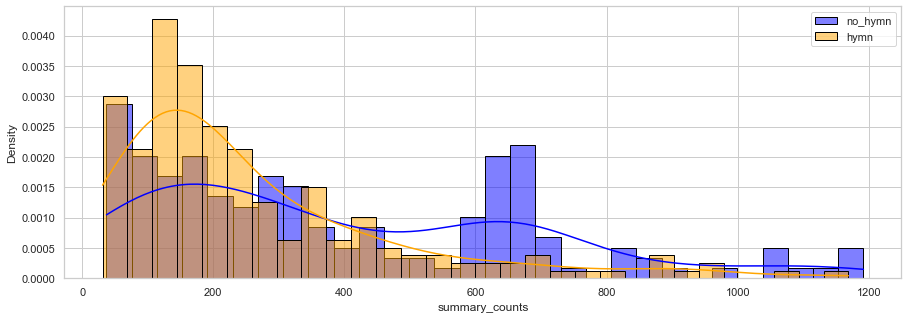

In [67]:
# Plot new density histogram using 'summary_counts'
hymn = df0.loc[df0['is_hymn']== 1]['summary_counts']
no_hymn = df0.loc[df0['is_hymn']== 0]['summary_counts']

plt.figure(figsize=(15, 5))

# Plot for 'no_hymn'
sns.histplot(no_hymn, kde=True, color='blue', label='no_hymn', edgecolor='black', stat='density', bins=30)

# Plot for 'hymn'
sns.histplot(hymn, kde=True, color='orange', label='hymn', edgecolor='black', stat='density', bins=30)

plt.legend()
plt.show()

##### Note: Word count distributions are more in line
* No need to upscale hymn=0 yet, since df is not horribly imbalanced
* No need to double word count on hymn=1 yet, though hymn=0 is still skewed toward longer texts

In [68]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   b_category            364 non-null    object 
 1   god                   232 non-null    object 
 2   number                364 non-null    object 
 3   whole_polarity        364 non-null    float64
 4   whole_subjectivity    364 non-null    float64
 5   word_count            364 non-null    int64  
 6   tfidf_top_word        364 non-null    object 
 7   cleaned_text          364 non-null    object 
 8   sentence_count        364 non-null    int64  
 9   is_hymn               364 non-null    int64  
 10  summary               364 non-null    object 
 11  lemmatized_summaries  364 non-null    object 
 12  summary_counts        364 non-null    int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 37.1+ KB


## Explanation of features in df0
Built, wrangled, and transformed from `all_texts_sentiment.csv` and `top_word_df.csv`

| Index | Feature                                           | Contents                                                                                                                                                                   |
|---|------------------------------------------|------------------------------------------------------------------------------------------|
| 0|b_category                                         | designations hold true to the original catalog          |
| 1|god                                        | featured god in text        |
| 2|number                          | original catalog number and **key**                                       |
| 3|whole_polarity       | whole assessment scores for each `joined_text` from `all_texts_sentiment.csv`               |
| 4|whole_subjectivity   | whole assessment scores for each `joined_text` from `all_texts_sentiment.csv`               |
| 5|word_count        | original word count from unsummarized lemmatized texts in `lemmatized` from `top_word_df.csv`        |
| 6|tfidf_top_word   | weighted top bi-gram from unsummarized lemmatized texts  in `lemmatized`  from `top_word_df.csv` |
| 7|cleaned_text       | original `text` from `all_texts_sentiment.csv` which has gone through multiple cleanings  |
| 8|sentence_count   | sentence counts for original `text` from `all_texts_sentiment.csv`                        |
| 9|is_hymn          |  binary genre division between hymn(1) and not hymn(0); **target variable**        |
| 10|summary   | extracted summaries of `cleaned_text` that were over 1200 words in length, summarized to at most 1200 words  |
| |          |  texts originally under 1200 words remained intact      |
| 11|lemmatized_summaries        | cleaned and lemmatized summaries in `summary`                                  |
| 12|summary_counts       | word counts for texts in `lemmatized_summaries`  |

#### Columns to drop for predictive csv `ancient_for_ML`
* 1 god: too informative
* 7 cleaned_text: no longer needed since contains full length texts
* 12 summary_counts: this feature was created simply to compare summarized text counts

#### To be kept
* 0 b_category: original genre category - will be removed for training
* 2 number:  original identification number - will be removed for training
* 3 whole_polarity
* 4 whole_subjectivity
* 5 original word_count
* 6 original tfidf_top_word
* 8 original sentence_count
* 9 is_hymn - **target variable**
* 10 summary
* 11 lemmatized_summaries

In [69]:
print(df0.columns)

Index(['b_category', 'god', 'number', 'whole_polarity', 'whole_subjectivity',
       'word_count', 'tfidf_top_word', 'cleaned_text', 'sentence_count',
       'is_hymn', 'summary', 'lemmatized_summaries', 'summary_counts'],
      dtype='object')


In [70]:
# Select columns to work with
ancient_for_ML = df0.drop(df0.columns[[1, 7, 12]], axis=1)

In [71]:
print(ancient_for_ML.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   b_category            364 non-null    object 
 1   number                364 non-null    object 
 2   whole_polarity        364 non-null    float64
 3   whole_subjectivity    364 non-null    float64
 4   word_count            364 non-null    int64  
 5   tfidf_top_word        364 non-null    object 
 6   sentence_count        364 non-null    int64  
 7   is_hymn               364 non-null    int64  
 8   summary               364 non-null    object 
 9   lemmatized_summaries  364 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 28.6+ KB
None


In [72]:
ancient_for_ML.head(2).round(2)

,b_category,number,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,sentence_count,is_hymn,summary,lemmatized_summaries
0,Narratives featuring deities,1.1.1,0.33,0.56,1440,oil like,167,0,pure is dilmun land. pure is dilmun land. pure...,pure dilmun land pure dilmun land pure dilmun ...
1,Narratives featuring deities,1.1.2,0.11,0.45,825,could not,81,0,"in those days, in the days when heaven and ear...",day day heaven earth created night night heave...


In [73]:
# Save final joined df to a CSV 
ancient_for_ML.to_csv('ancient_for_ML.csv', index=False)
df0 = pd.read_csv('ancient_for_ML.csv')
print(df0.info())
df0.head(2).round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   b_category            364 non-null    object 
 1   number                364 non-null    object 
 2   whole_polarity        364 non-null    float64
 3   whole_subjectivity    364 non-null    float64
 4   word_count            364 non-null    int64  
 5   tfidf_top_word        364 non-null    object 
 6   sentence_count        364 non-null    int64  
 7   is_hymn               364 non-null    int64  
 8   summary               364 non-null    object 
 9   lemmatized_summaries  364 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 28.6+ KB
None


,b_category,number,whole_polarity,whole_subjectivity,word_count,tfidf_top_word,sentence_count,is_hymn,summary,lemmatized_summaries
0,Narratives featuring deities,1.1.1,0.33,0.56,1440,oil like,167,0,pure is dilmun land. pure is dilmun land. pure...,pure dilmun land pure dilmun land pure dilmun ...
1,Narratives featuring deities,1.1.2,0.11,0.45,825,could not,81,0,"in those days, in the days when heaven and ear...",day day heaven earth created night night heave...
